In [200]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from prophet import Prophet
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [202]:
dfo = pd.read_csv('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AEP_hourly.csv')

In [204]:
dfo['Datetime'] = pd.to_datetime(dfo['Datetime'])
#df.set_index('Datetime', inplace = True)
#df.sort_index(inplace = True)

In [206]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='W')).sum()

In [208]:
df.sort_index(inplace = True)

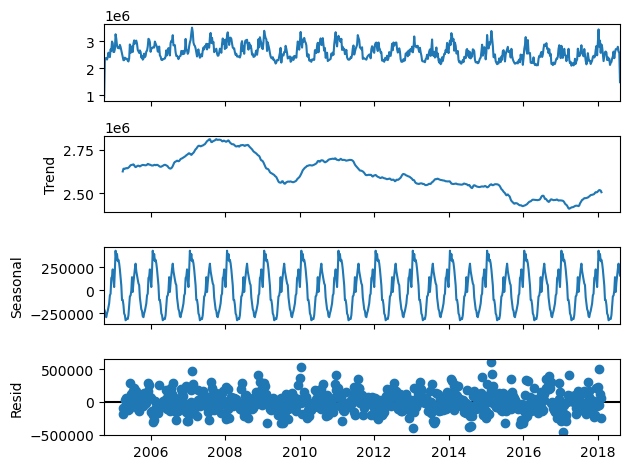

In [6]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 52)
decomp_a.plot()
plt.show()

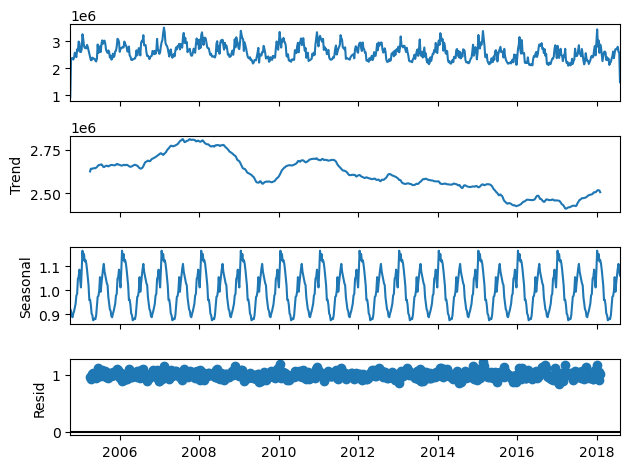

In [7]:
decomp_b = seasonal_decompose(df, model = 'multiplicative', period = 52)
decomp_b.plot()
plt.show()

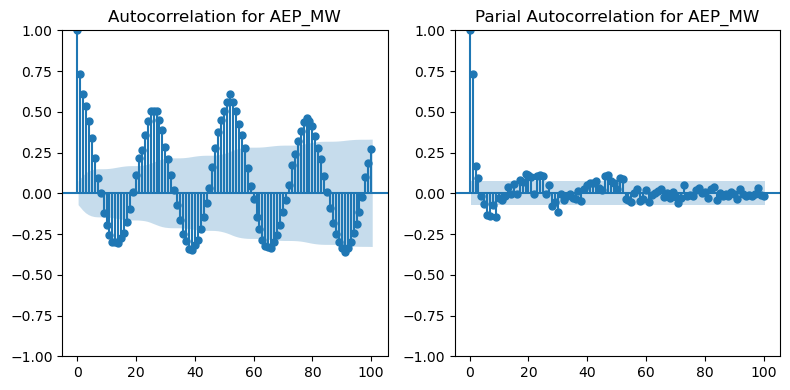

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=100, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=100, ax=axes[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW")

plt.tight_layout()
plt.show()

In [210]:
dfm = df.copy()

In [212]:
dfm['AEP_MW_ln'] = np.log(dfm['AEP_MW'])

In [214]:
dfd = dfm.diff(1).diff(52)

In [216]:
dfd = dfd.dropna()

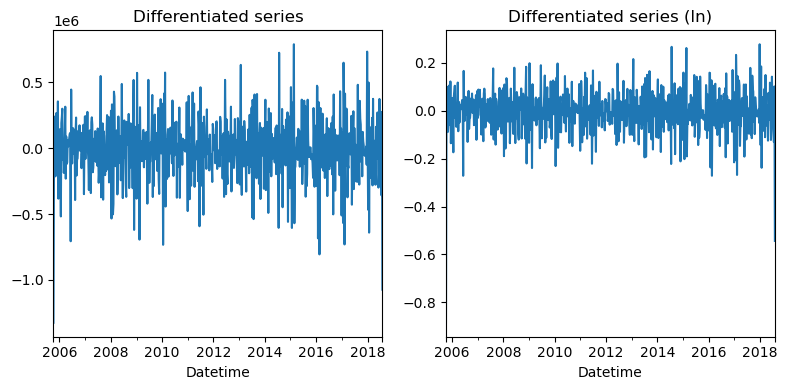

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

dfd['AEP_MW'].plot(ax=axes[0]) 
axes[0].set_title("Differentiated series")

dfd['AEP_MW_ln'].plot(ax=axes[1])
axes[1].set_title("Differentiated series (ln)")

plt.tight_layout()
plt.show()

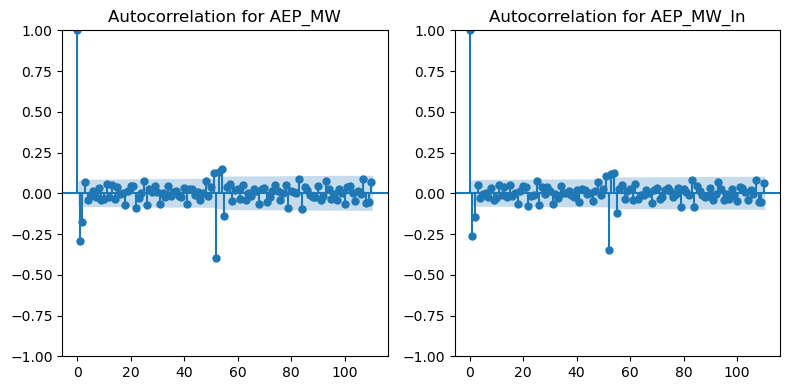

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_acf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

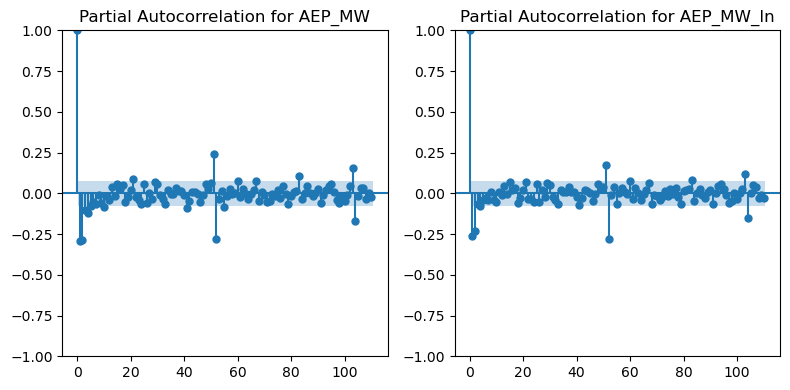

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

In [31]:
adt1, adt2 = adfuller(dfd['AEP_MW']), adfuller(dfd['AEP_MW_ln'])
print(f"p-value szeregu {adt1[1]}, p-value szeregu ln {adt2[1]}")

p-value szeregu 3.6978756890071637e-23, p-value szeregu ln 1.8725339365726934e-22


In [218]:
combinations = list(itertools.product([0, 1, 2], repeat=4))
matrix = np.array(combinations)
dfL = pd.DataFrame(matrix, columns = ['p', 'q', 'P', 'Q'])
dfL.drop(0, inplace = True)
dfL['AIC'] = 0
dfL['BIC'] = 0

dfL2 = dfL.copy()

In [220]:
data_train = dfm.loc['2005-01-01':'2017-12-31', :]
data_test = dfm.loc['2018-01-01':'2018-06-30', :]

In [37]:
# for i in tqdm(dfL.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW'], order = (dfL.loc[i, 'p'], 1, dfL.loc[i, 'q']), seasonal_order = (dfL.loc[i, 'P'], 1, dfL.loc[i, 'Q'], 52))
#     model = model.fit()
#     dfL.loc[i, 'AIC'] = model.aic
#     dfL.loc[i, 'BIC'] = model.bic
# for i in tqdm(dfL2.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW_ln'], order = (dfL2.loc[i, 'p'], 1, dfL2.loc[i, 'q']), seasonal_order = (dfL2.loc[i, 'P'], 1, dfL2.loc[i, 'Q'], 52))
#     model = model.fit()
#     dfL2.loc[i, 'AIC'] = model.aic
#     dfL2.loc[i, 'BIC'] = model.bic

In [222]:
dfL = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AIC1.pkl')
dfL2 = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AIC2.pkl')

In [224]:
df_IC = pd.concat([dfL.loc[[dfL['AIC'].idxmin()]], dfL.loc[[dfL['BIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]]])

In [226]:
df_IC.reset_index(drop = True, inplace= True)

In [51]:
models = []
for i in range(3):
    if i < 2:
        model = SARIMAX(data_train['AEP_MW'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 52))
    else:
        model = SARIMAX(data_train['AEP_MW_ln'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 52))
    models.append(model.fit())

Model nr 0


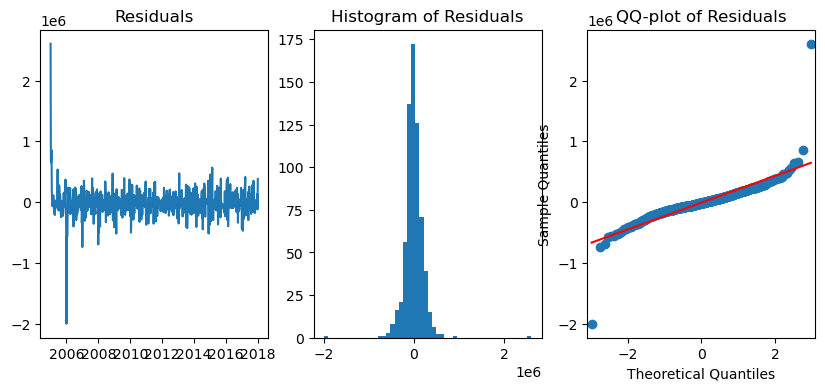

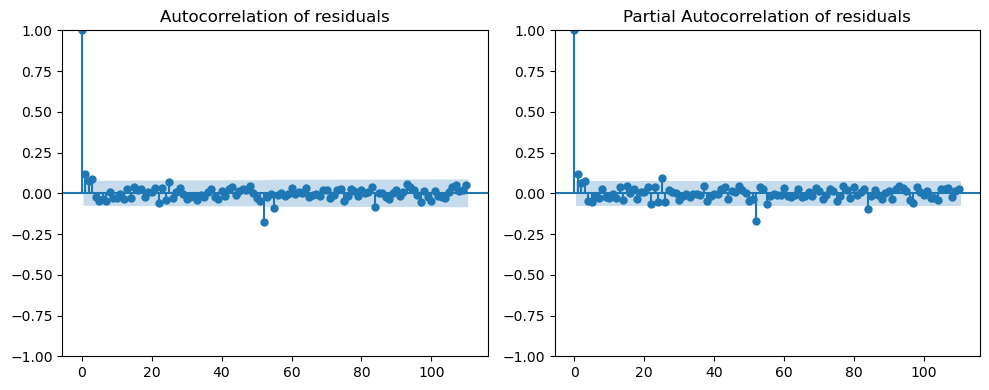

Model nr 1


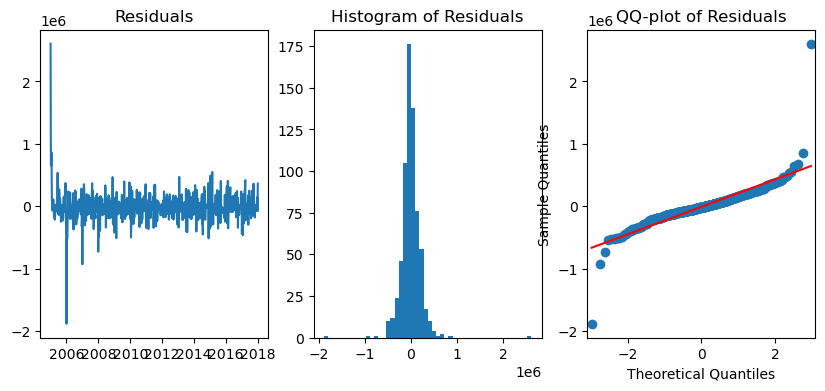

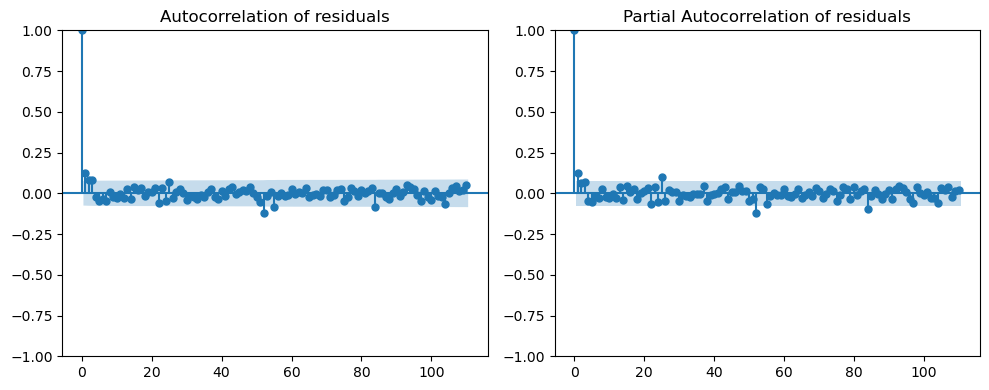

Model nr 2


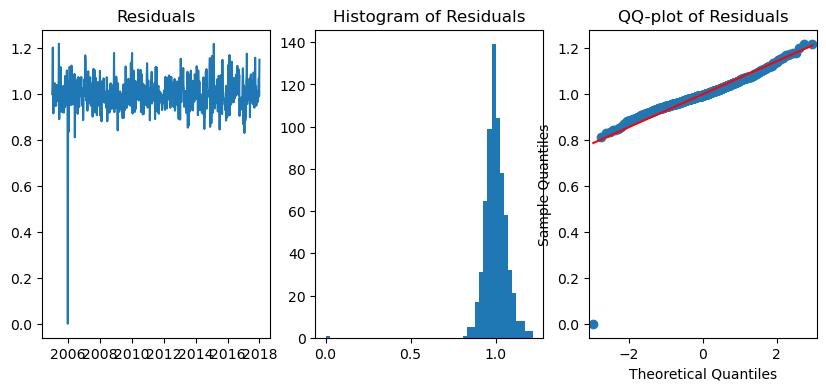

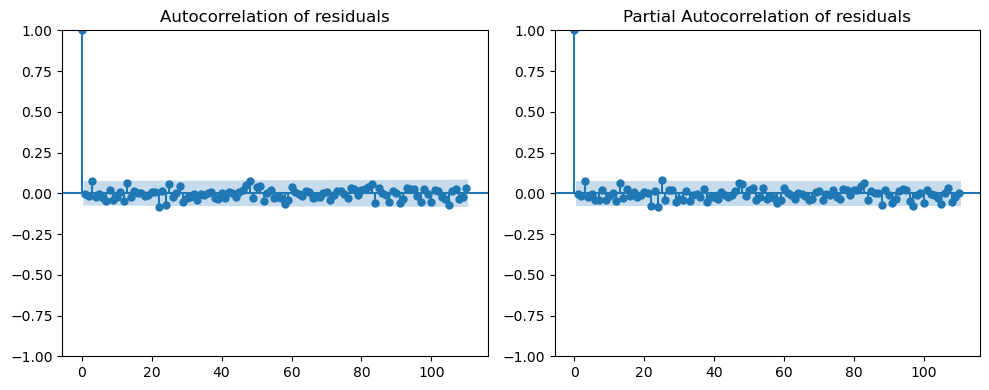

In [71]:
for i in range(3):

    print(f'Model nr {i}')
    model_fit = models[i]

    if i < 2:
        resid = model_fit.resid
    else: 
        resid = np.exp(model_fit.resid[1:])


    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].plot(resid)
    axes[0].set_title("Residuals")

    axes[1].hist(resid, bins=50)
    axes[1].set_title("Histogram of Residuals")

    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot of Residuals")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(resid, lags=110, ax=axes[0])
    axes[0].set_title("Autocorrelation of residuals")

    plot_pacf(resid, lags=110, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation of residuals")

    plt.tight_layout()
    plt.show()

In [228]:
df_pred = data_test[['AEP_MW']].copy()

In [230]:
for i in range(3):
    
    #print(f'Model nr {i}')
    model_fit = models[i]
    pred = model_fit.predict(start = '2018-01-07', end = '2018-06-24')
    if i < 2:
        df_pred[f'Pred no {i}'] = pred
    else:
        df_pred[f'Pred no {i}'] = np.exp(pred)

In [232]:
###prophet

In [234]:
dfp1 = data_train[['AEP_MW']].copy()
dfp2 = data_train[['AEP_MW_ln']].copy()

In [236]:
dfp1.reset_index(inplace = True)
dfp2.reset_index(inplace = True)

In [238]:
dfp1.columns = ['ds', 'y']
dfp2.columns = ['ds', 'y']

In [240]:
modelp1 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)
modelp2 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)

In [242]:
modelp1.add_seasonality(name='yearly', period=52, fourier_order=5)
modelp1.add_seasonality(name='weekly', period=1, fourier_order=3)

modelp2.add_seasonality(name='yearly', period=52, fourier_order=5)
modelp2.add_seasonality(name='weekly', period=1, fourier_order=3)

In [244]:
modelp_fit1 = modelp1.fit(dfp1)
modelp_fit2 = modelp2.fit(dfp2)

18:38:38 - cmdstanpy - INFO - Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing
18:38:38 - cmdstanpy - INFO - Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing


In [246]:
future = modelp_fit1.make_future_dataframe(periods=25, freq = 'W')

In [248]:
predp1 = modelp_fit1.predict(future)[['ds', 'yhat']]
predp2 = modelp_fit2.predict(future)[['ds', 'yhat']]

In [250]:
df_pred = df_pred.merge(predp1.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 3'}, axis =1, inplace = True)

In [252]:
df_pred = df_pred.merge(predp2.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 4'}, axis =1, inplace = True)

In [254]:
df_pred['Pred no 4'] = np.exp(df_pred['Pred no 4'])

In [256]:
## trend + sezonowosc 

In [258]:
df_ts = data_train.copy()

In [262]:
vals_x = np.arange(len(df_ts))
vals_y1 = df_ts[['AEP_MW']].values
vals_y2 = df_ts[['AEP_MW_ln']].values

In [264]:
poly = PolynomialFeatures(degree=3)
vals_x_poly = poly.fit_transform(vals_x.reshape(-1, 1))

In [266]:
model_poly1 = LinearRegression().fit(vals_x_poly, vals_y1)
model_poly2 = LinearRegression().fit(vals_x_poly, vals_y2)

In [268]:
df_ts['Trend'] = model_poly1.predict(vals_x_poly)
df_ts['Trend_ln'] = model_poly2.predict(vals_x_poly)

In [270]:
df_ts['Detrend'] = df_ts['AEP_MW'] - df_ts['Trend']
df_ts['Detrend_ln'] = df_ts['AEP_MW_ln'] - df_ts['Trend_ln']

In [272]:
df_ts = df_ts.loc[df_ts['Trend'].notna(), :]
df_ts = df_ts.loc[df_ts.index.year > 2004]

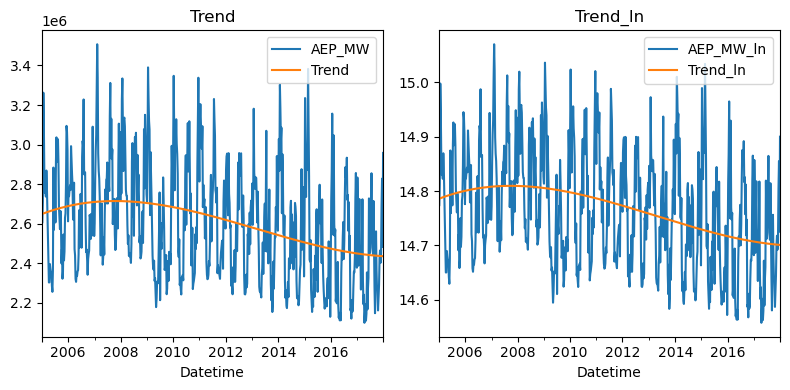

In [274]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[0, 2]]].plot(ax=axes[0])
axes[0].set_title("Trend")

df_ts.loc[:, df_ts.columns[[1, 3]]].plot(ax=axes[1])
axes[1].set_title("Trend_ln")

plt.tight_layout()
plt.show()

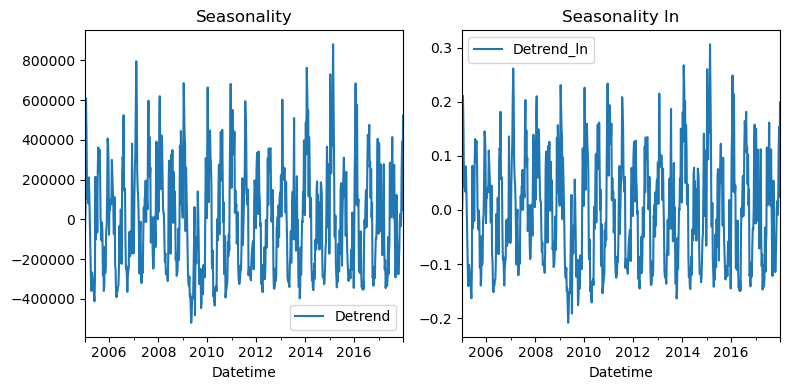

In [276]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[4]]].plot(ax=axes[0])
axes[0].set_title("Seasonality")

df_ts.loc[:, df_ts.columns[[5]]].plot(ax=axes[1])
axes[1].set_title("Seasonality ln")

plt.tight_layout()
plt.show()

In [280]:
df_ts['Week no'] = np.nan
curr_year = df_ts.index[0].year
i = 1
for j in df_ts.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts.loc[j, 'Week no'] = i
        curr_year = next_year
    else:
        df_ts.loc[j, 'Week no'] = i
        i = i + 1

In [282]:
df_ts = df_ts.reset_index().merge(df_ts[['Week no', 'Detrend', 'Detrend_ln']].reset_index(drop = True).groupby('Week no').mean().rename({'Detrend':'Seasonality', 'Detrend_ln':'Seasonality_ln'}, axis = 1), left_on = 'Week no', right_on = 'Week no')

In [284]:
df_ts = df_ts.set_index('Datetime').sort_index()

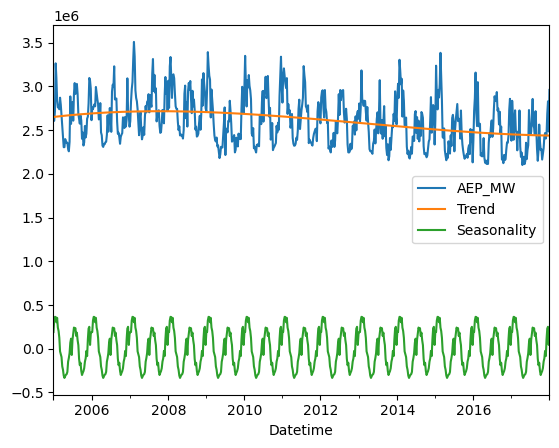

In [288]:
df_ts[['AEP_MW', 'Trend', 'Seasonality']].plot()
plt.show()

In [440]:
df_ts_pred = data_test.copy()

In [442]:
df_ts_pred['Week no'] = np.nan
curr_year = df_ts_pred.index[0].year
i = 1
for j in df_ts_pred.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts_pred.loc[j, 'Week no'] = i
        curr_year = next_year
    else:
        df_ts_pred.loc[j, 'Week no'] = i
        i = i + 1

In [444]:
df_ts_pred = df_ts_pred.reset_index().merge(df_ts[['Week no', 'Seasonality', 'Seasonality_ln']].head(25), left_on = 'Week no', right_on = 'Week no', how = 'left')

In [446]:
vals_x_p = np.arange(vals_x[-1] + 1, vals_x[-1] + 26)

In [448]:
vals_x_poly_p = poly.fit_transform(vals_x_p.reshape(-1, 1))

In [450]:
df_ts_pred['Trend'] = model_poly1.predict(vals_x_poly_p)
df_ts_pred['Trend_ln'] = model_poly2.predict(vals_x_poly_p)

In [452]:
df_ts_pred['Pred'] = df_ts_pred['Trend'] + df_ts_pred['Seasonality']
df_ts_pred['Pred_ln'] = df_ts_pred['Trend_ln'] + df_ts_pred['Seasonality_ln']

In [454]:
df_ts_pred.set_index('Datetime', inplace =  True)

In [456]:
df_ts_pred['Pred_ln'] = np.exp(df_ts_pred['Pred_ln'])

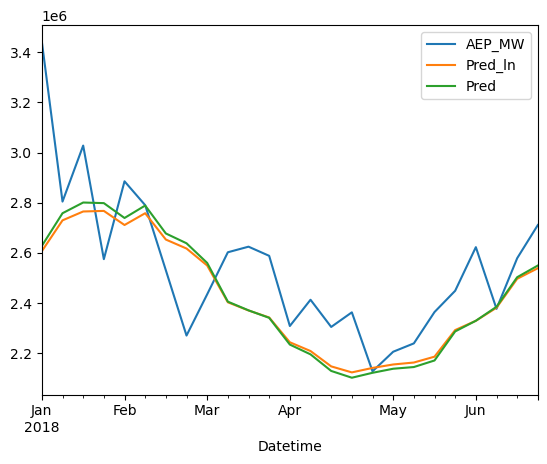

In [458]:
df_ts_pred[['AEP_MW','Pred_ln', 'Pred']].plot()
plt.show()

In [468]:
df_ts_pred.rename({'Pred':'Pred no 5', 'Pred_ln':'Pred no 6'}, axis = 1, inplace = True)

In [476]:
df_pred = df_pred.merge(df_ts_pred[['Pred no 5', 'Pred no 6']], left_index = True, right_index = True)

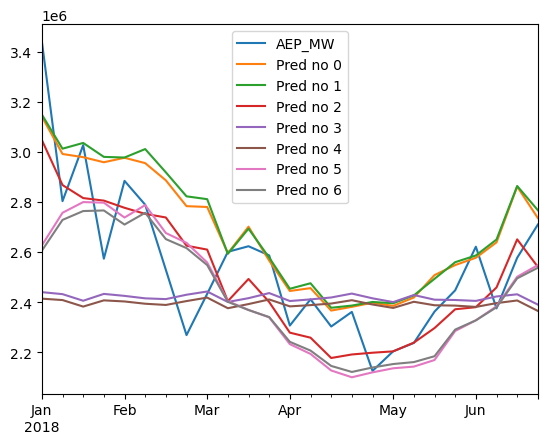

In [478]:
df_pred.plot()
plt.show()

In [486]:
for i in range(1,8):
    err = df_pred['AEP_MW'] - df_pred[df_pred.columns[i]]
    df_pred[f'Err no {i}'] = err
df_err = pd.DataFrame(index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7'],columns = ['L2', 'L3', 'AL2', 'AL3'])

In [488]:
LP2 = ((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]**2).sum(axis = 0))**(1/2)
LP3 = (np.abs(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]**3).sum(axis = 0))**(1/3)
ALP2 = (((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']] < 0, 1.1, 0.9))**2).sum(axis = 0))**(1/2)
ALP3 = (np.abs((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']] < 0, 1.1, 0.9))**3).sum(axis = 0))**(1/3)

In [490]:
df_err.loc[:, 'L2'] = LP2.values
df_err.loc[:, 'L3'] = LP3.values
df_err.loc[:, 'AL2'] = ALP2.values
df_err.loc[:, 'AL3'] = ALP3.values

In [492]:
df_err

,L2,L3,AL2,AL3
Model 1,1087033.150815,737583.826561,1179715.177865,802903.583109
Model 2,1154087.609588,784883.127264,1255718.236227,856562.108433
Model 3,864355.296006,577523.643279,846349.463371,569912.805489
Model 4,1551437.403957,1160285.04121,1427201.240137,1052694.006581
Model 5,1603648.243575,1197454.605692,1465737.391883,1083232.141682
Model 6,1214643.156243,904120.880231,1133261.70776,833336.662269
Model 7,1213883.757495,915935.490263,1126081.595026,839551.224667
